In [47]:
from torchvision import datasets
from torchvision import transforms as T
import torch
import numpy as np

In [22]:
pip install torch==2.2.2

Note: you may need to restart the kernel to use updated packages.


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.notebook import tqdm
import utils

In [2]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor(), #h,w,c -> c,h,w
    T.Normalize(mean=0.5,std=0.5)
])

valid_augs = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=0.5,std=0.5)
])


In [6]:
trainset = datasets.MNIST('./', download=True, train=True, transform=train_augs)
testset=datasets.MNIST('./', download=True, train=False,transform=valid_augs)


In [7]:
trainset, validset = torch.utils.data.random_split(trainset,[50000,10000])

In [12]:
print(f"test set :{len(testset)}")
print(f"train set :{len(trainset)}")
print(f"valid set :{len(validset)}")

test set :10000
train set :50000
valid set :10000


In [17]:
import matplotlib.pyplot as plt


shape of image: torch.Size([1, 28, 28])
permuting shape: torch.Size([28, 28, 1])


Text(0.5, 1.0, 'label')

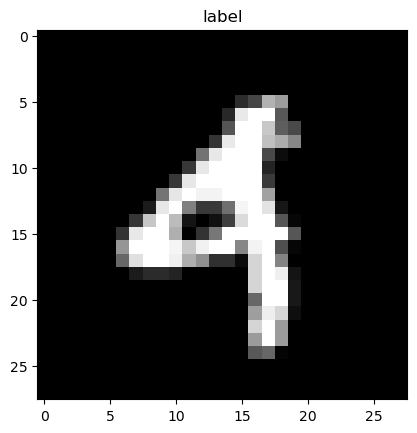

In [18]:
idx=1
image,label = trainset[idx]
print(f'shape of image: {image.shape}')
#for vis we need h,w,c so we'll permute
print(f'permuting shape: {image.permute(1,2,0).shape}')
plt.imshow(image.permute(1,2,0),cmap='gray')
plt.title('label')

In [19]:
from torch.utils.data import DataLoader

In [21]:
bs = 64
tr_load=DataLoader(trainset,batch_size=bs,shuffle=True)
test_load=DataLoader(testset,batch_size=bs)
valid_load=DataLoader(validset,batch_size=bs)

In [23]:
print(f'Total number of batch in train set : {len(tr_load)}')
print(f'test number of batch in train set : {len(test_load)}')
print(f'Total number of batch in valid set : {len(valid_load)}')


Total number of batch in train set : 782
test number of batch in train set : 157
Total number of batch in valid set : 157


In [25]:
for images,labels in tr_load:
    print(f'one image batch shape : {images.shape}')
    print(f'one label batch shape : {labels.shape}')
    break;

one image batch shape : torch.Size([64, 1, 28, 28])
one label batch shape : torch.Size([64])


In [26]:
#cross entropy loss pytorch takes input as logits, so in model.py we're not applying softmax

In [29]:
from models import DigitModel

model=DigitModel()
model.to('cpu')

DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_featu

In [56]:
def train_fn(model,dataloader,criterion,optimizer):
    model.train()
    tot_acc=0.0
    tot_loss=0.0
    
    for images,labels in tqdm(dataloader):
        
        images=images.to('cpu')
        labels=labels.to('cpu')
        
        
        optimizer.zero_grad()
        logits=model(images)
        loss=criterion(logits,labels)
        loss.backward()
        optimizer.step()
        
        tot_acc+=utils.multiclass_accuracy(logits,labels)
        tot_loss+=loss.item()
        
    return tot_loss/len(dataloader) , tot_acc/len(dataloader)

In [57]:
def eval_fn(model,dataloader,criterion):
    model.train()
    tot_acc=0.0
    tot_loss=0.0
    
    with torch.no_grad():
    
        for images,labels in tqdm(dataloader):

            images=images.to('cpu')
            labels=labels.to('cpu')


            logits=model(images)
            loss=criterion(logits,labels)

            tot_acc+=utils.multiclass_accuracy(logits,labels)
            tot_loss+=loss.item()
        
    return tot_loss/len(dataloader) , tot_acc/len(dataloader)

In [58]:
criterion = torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [59]:
best_valid_loss=np.Inf

for i in range(10):
    train_loss,train_acc = train_fn(model,tr_load,criterion,optimizer)
    valid_loss,valid_acc = eval_fn(model,tr_load,criterion)
    
    print(f"epoch {i+1} Train Loss : {train_loss} train acc : {train_acc}")
    print(f"epoch {i+1} valid Loss : {valid_loss} valid acc : {valid_acc}")
    
    if valid_loss<best_valid_loss:
        torch.save(model.state_dict(), 'best-wt.pt')
        print('saved model !')
        best_valid_loss = valid_loss

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 1 Train Loss : 0.20918469511382187 train acc : 0.9384790658950806
epoch 1 valid Loss : 0.18535057614173958 valid acc : 0.9449528455734253
saved model !


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 2 Train Loss : 0.18039826681013302 train acc : 0.9459918737411499
epoch 2 valid Loss : 0.15952611697451843 valid acc : 0.9517862796783447
saved model !


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 3 Train Loss : 0.15981998598998617 train acc : 0.9528452754020691
epoch 3 valid Loss : 0.1503264620552397 valid acc : 0.9550431370735168
saved model !


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 4 Train Loss : 0.15358056778045337 train acc : 0.9550631642341614
epoch 4 valid Loss : 0.13316265867589533 valid acc : 0.9610773921012878
saved model !


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 5 Train Loss : 0.14368098130201934 train acc : 0.9575807452201843
epoch 5 valid Loss : 0.13353902166423476 valid acc : 0.9608975648880005


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 6 Train Loss : 0.12985516174355774 train acc : 0.9612371921539307
epoch 6 valid Loss : 0.1280203178713141 valid acc : 0.96263587474823
saved model !


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 7 Train Loss : 0.12584927195952275 train acc : 0.962695837020874
epoch 7 valid Loss : 0.12211192102121461 valid acc : 0.9630154967308044
saved model !


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 8 Train Loss : 0.11875926966414503 train acc : 0.9647738337516785
epoch 8 valid Loss : 0.11113900781544807 valid acc : 0.9662124514579773
saved model !


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 9 Train Loss : 0.11725407562580654 train acc : 0.9654931426048279
epoch 9 valid Loss : 0.10631238439988555 valid acc : 0.9683504104614258
saved model !


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 10 Train Loss : 0.11517289219140682 train acc : 0.9666520357131958
epoch 10 valid Loss : 0.0976763750206741 valid acc : 0.9699288606643677
saved model !


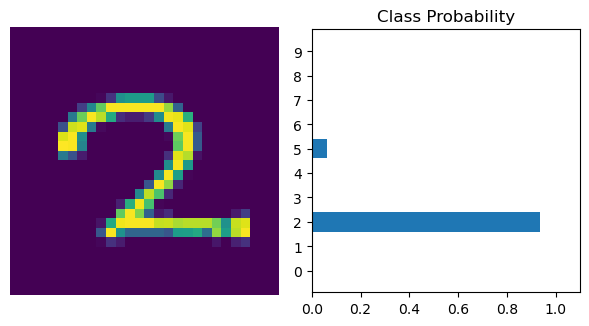

In [67]:
image,label = testset[77]

weights = torch.load('best-wt.pt')
model.load_state_dict(weights)
model.eval()

with torch.no_grad():
    logits=model(image.unsqueeze(0)) #bcoz model takes in the format of batch_size,c,h,w
    ps=torch.nn.Softmax(dim=1)(logits)[0]
    utils.view_classify(image,ps)